In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import copy

#plt.rcParams["figure.figsize"] = [5, 5]


<center>

# TP2 - Mariages stables équitables
2024/2025 - T. Godin, L. Naert
</center>

Dans le TP précédent, nous avons vu que l'algorithme de Gale-Shapley permet de donner une solution au problème des mariages stables entre deux populations $P_1$ et $P_2$ tout en avantageant l'une ou l'autre des parties. Dans notre exemple, les étudiants avaient, en moyenne moins de regret que les formations. Les préférences des étudiants étaient mieux respectées que celle des formations.


On peut essayer de résoudre ce problème. Malheureusement "Gusfield and Irving introduced the equitable stable marriage problem (ESMP), which calls for finding a stable matching that minimizes the 
distance between men's and women's sum-of-rankings of their spouses. 
Unfortunately, ESMP is strongly NP-hard" 
(_I. Giannakopoulos, P. Karras, D. Tsoumakos, K. Doka and N. Koziris, "An Equitable Solution to the Stable Marriage Problem," 2015 IEEE 27th ICTAI, 2015,  doi: 10.1109/ICTAI.2015.142._)

On va donc essayer d'être plus équitable, tout en restant computationnellement raisonnables.


__Définitions :__
 - Pour rappel, on appelle regret d’un étudiant (ou plus généralement, d'un élément de $P_1$) désigne le rang, parmi ses préférences, de la formation (ou plus généralement, de l'élément de $P_2$) avec qui il est apparié. On définit de même le regret d’une formation.
 - Le regret maximal est le maximum des regrets de tous les individus (ici, formations et étudiants)

Dans ce TP vous allez implémenter l'algorithme de Selkow permettant d'avoir un mariage stable équitable, c'est à dire un mariage qui minimise le regret maximal (le regret de l'individu le plus malheureux). 


## Rappel de la structure de données et des fonctions utiles

Nous utilisons toujours des dictionnaires pour stocker la structure de données :

In [2]:
etudPref = {1:[2, 3, 0, 1, 4], 2:[4, 0, 1, 2, 3], 0:[4, 1, 2, 0, 3], 3:[3, 1, 4, 0, 2], 4:[3, 4, 1, 2, 0]}

formaPref = {1:[3, 4, 0, 2, 1], 2:[1, 3, 0, 4, 2], 3:[1, 4, 3, 2, 0], 0:[2, 1, 0, 3, 4], 4:[3, 1, 4, 2, 0]}


La clef du dictionnaire donne l'identifiant de l'individu (étudiant ou formation) et la valeur correspondante présente la liste des préférence de l'individu en question. On peut voir, par exemple, que l'étudiant n°0 voudrait aller dans la formation n°4 en priorité, puis la 1, la 2, etc.

In [3]:
print("Liste des préférences de l'étudiant 2 : ", etudPref[2])
print("Liste des préférences de la formation 4 : ", formaPref[4])
print("Formation préférée de l'étudiant 3 : ",etudPref[3][0])


Liste des préférences de l'étudiant 2 :  [4, 0, 1, 2, 3]
Liste des préférences de la formation 4 :  [3, 1, 4, 2, 0]
Formation préférée de l'étudiant 3 :  3


De la même façon, un mariage est également un dictionnaire où les couples (clef, valeur) représente un mariage entre un individu de la population 1 (clef) et un individu de la population 2 (valeur). Un exemple est donné ci-dessous : 

In [4]:
mariage = {0:0, 2:4, 4:-1, 3:1, 1:2}


Si l'on considère que $P_1$ (population 1) rassemble les étudiants et $P_2$ (population 2) les formations. On voit par exemple que l'étudiant 2 est marié à la formation 4 et l'étudiant 4 n'est pas marié.

Nous avons remis ici les fonctions codées dans le TP précédent :

Les fonctions suivantes ont été réécrites pour prendre en compte la nouvelle structure de données : 
- `prefer(pref,c1,c2)` : indique si c1 est préféré à c2, 
- `galeShapley` : execute l'algorithme de Gale Shapley,
- `regret` : calcule le regret d'un élément et 
- `regrets` : donne les regrets de chaque individu dans deux dictionnaires.

Comprenez-vous les résultats affichés pour les méthodes `regret` et `regrets` ? 

In [14]:
def prefer(pref,c1,c2):
    """
    renvoie True si c1 est préféré à c2 d'après la liste des préférence pref.


   :param array pref: la liste de préférences
   :param int c1: premier individu
   :param int c1: deuxième individu   
   :return: True si c1 est préféré à c2, False si c2 est préféré à c1 ou si c1 n'est pas dans la liste
   :rtype: bool
    """
    if(c1 in pref and c2 in pref): 
        return pref.index(c1)<pref.index(c2)
    else:
        return False

def dicoPrefGenerator(n):
    # Générer une liste de tous les entiers de 0 à n-1
    all_numbers = list(range(n))
    prefDico= {}
    for i in range(n):
        pref = random.sample(all_numbers, n)
        prefDico[i] = pref
    
    return prefDico

def marriedTo(marriage,e,isP1):
    """
    renvoie l'identifiant du partenaire de e d'après le dictionnaire des mariages marriage,
    et -1 s'il n'est pas marié

   :param dictionnary marriage: la liste des mariages actuels
   :param int e: élément de P1 ou de P2
   :param bool isP1: permet de connaitre le rôle de e (P1 ou P2)
   :return: l'identifiant du partenaire de e d'après marriage
   :rtype: int
    """
    if(isP1):
        return marriage[e]
    else :
        if not(e in list(marriage.values())):
            return -1
        else:
            return list(marriage.keys())[list(marriage.values()).index(e)]

def galeShapley(p1Pref,p2Pref):
    """
    renvoie un dictionnaire de mariages stables
    
    
   :param dictionnaire p1Pref: le dictionnaire des préférences des individus de P1
   :param dictionnaire p2Pref: le dictionnaire des préférences des individus de P2
   :return: dictionnaire de mariages stables
   :rtype: dictionnaire
    """ 
    
    # Au départ : personne n'est apparié.
    marriage={i:-1 for i in list(p1Pref.keys())}
    
    # Créer un tableau pour suivre le progrès de chaque element de P1 (l'indice de P2 demandé en mariage)
    p1Progress = [0] * (max(p1Pref.keys())+1)
    
    # Liste pour stocker les éléments de P1 célibataires (pleine au départ)
    singleP1 = list(p1Pref.keys())
    while(singleP1):

        elemP1 = singleP1[0]
        elemP2 = p1Pref[elemP1][p1Progress[elemP1]]
        
        p1Progress[elemP1] +=1
        fiancee = marriedTo(marriage, elemP2, False) #on vérifie que l'element de P2 est celibataire
        # l'element de P2 est celibataire
        if(fiancee == -1):
            marriage[elemP1] = elemP2
            singleP1.remove(elemP1)
        else : 
            # l'element de P2 est mariee
            if(prefer(p2Pref[elemP2],elemP1,fiancee) == True): #mariage instable
                marriage[elemP1] = elemP2
                marriage[fiancee] = -1
                singleP1.remove(elemP1)
                singleP1.append(fiancee)
    return marriage

def regret(mariage, e, p1Pref, p2Pref, isP1):
    """
    renvoie le regret de e
    
    
   :param int e indice d'un etudiant ou d'une université
   :param array mariage résultat d'un mariage
   :param dictionnaire p1Pref: le dictionnaire des préférences des individus de P1
   :param dictionnaire p2Pref: le dictionnaire des préférences des individus de P2
   :param bool isP1: permet de connaitre la population d'appartenance de e
   
   :return: regret
   :rtype: int
    """  
        
        
    if isP1:
        pref_list = p1Pref[e]
    else:
        pref_list = p2Pref[e]
    regret = len(pref_list)
    mari = marriedTo(mariage, e, isP1)
    if mari != -1:
        if isP1:
            regret = pref_list.index(mari)
        else:
            regret = pref_list.index(mari)
    return regret


def regrets(mariage, p1Pref, p2Pref):
    """
    renvoie une liste des regrets des éléments de P1 et des regrets des éléments de P2
    
   :param dictionnaire mariage résultat d'un mariage
   :param dictionnaire p1Pref le dictionnaire des préférences des individus de P1
   :param dictionnaire p2Pref le dictionnaire des préférences des individus de P2
   
   :return: regrets
   :rtype: liste de deux dictionnaires : le premier avec les regrets P1 et le deuxième avec les regrets de P2
    """ 
    
    
    tousRegrets = []
    regretP1 = {}
    regretP2 = {}
    for ep1 in list(p1Pref.keys()):
        regretP1[ep1] = regret(mariage,ep1, p1Pref, p2Pref, True )
    for ep2 in list(p2Pref.keys()):
        regretP2[ep2] = regret(mariage,ep2, p1Pref, p2Pref, False )
    tousRegrets.append(regretP1)
    tousRegrets.append(regretP2)
    return tousRegrets

etudPref ={0: [1, 4, 0, 2, 3], 1: [1,4, 0, 2, 3], 2: [3, 1, 2, 0, 4], 3: [3, 1, 4, 0, 2], 4: [1, 4, 0, 3, 2]}
formaPref ={0: [2, 0, 4, 3, 1], 1: [2, 3, 0, 4, 1], 2: [3, 2, 4, 0, 1], 3: [0, 4, 1, 2, 3], 4: [4, 3, 0, 2, 1]}
mariage = galeShapley(formaPref, etudPref)
print("Resultat du mariage avec galeShapleyDico : ", mariage)
print("Regret de l'étudiant 0 : ", regret(mariage, 0,etudPref, formaPref, True))
print("Regret de la formation 0 : ", regret(mariage, 0,etudPref, formaPref, False))
print("Regrets de tous le monde : ", regrets(mariage, etudPref, formaPref))


Resultat du mariage avec galeShapleyDico :  {0: 0, 1: 2, 2: 3, 3: 1, 4: 4}
Regret de l'étudiant 0 :  2
Regret de la formation 0 :  1
Regrets de tous le monde :  [{0: 2, 1: 3, 2: 0, 3: 1, 4: 1}, {0: 1, 1: 1, 2: 4, 3: 3, 4: 0}]


## Algorithme de Selkow

Décrivons maintenant le fonctionnement de l'algorithme de Selkow. 


**Entrées** : Préférences de $P_1$ et $P_2$

**Sortie** : Liste de mariages stables équitables

Initialisation : Personne n'est marié

Tant qu'un individu n'est pas marié : 
- Faire un Gale-Shapley **sur les individus non mariés**
- Suite à ce mariage, calculer les bornes supérieures et inférieures des regrets de chaque individu du mariage
- Pour chaque individu:
    - si la borne sup est égale à la borne inf : le mariage est considéré comme _non perfectible_. On le garde dans la liste des mariages finals.
    - sinon : le mariage est perfectible. Il est annulé (il n'est pas ajouté aux mariages finaux)
- S'il reste des individus non mariées : 
    - recherche de l'individu $e$ avec le regret maximal parmi les individus non mariés
    - Interdire la possibilité de refaire ce mariage (on retire $e$ de la liste de préférence de son partenaire et/ou on retire le partenaire de la liste des préférences de $e$)
    
    
Notez la besoin de calculer les bornes supérieures et inférieures des regrets de chaque individu !  L'algorithme de Selkow se base en effet sur une propriété interessante de Gale-Shapley pour fonctionner : le mariage résultant de Gale-Shapley est le mariage **le plus optimal** pour les éléments de $P_1$ et **le moins optimal** pour les éléments de $P_2$. 

Ainsi, après un mariage de type Gale-Shapley, le regret des éléments de $P_1$ sera donc minimal (borne inférieur des regrets de $P_1$) et celui des éléments de $P_2$ maximal (borne supérieure des regrets de $P_2$). Evidemment, si l'on exécute Gale-Shapley après avoir échangé $P_1$ et $P_2$ dans les paramètres, nous aurons donc une deuxième proposition de mariage qui avantage $P_2$, cette fois ci !
Le calcul des regrets sur ce nouveau mariage nous donnera la borne inférieure des regrets de $P_2$ et la borne supérieure des regrets de $P_1$. 


> __Question 1 (Bornes des regrets)__ : Ecrire une fonction `bornesSupInfGS(p1Pref, p2Pref)` qui renvoie les bornes inf et sup des deux populations. Cette fonction appelle donc Gale-Shapley !
Dans l'exemple donné dans le try/assert : quels partenaires sont dans des mariages perfectibles ? 


In [15]:
def bornesSupInfGS(p1Pref, p2Pref):
    """
    Renvoie une liste des bornes inférieures et supérieures des deux populations P1 et P2.
    
    :param dictionnaire p1Pref: le dictionnaire des préférences des individus de P1
    :param dictionnaire p2Pref: le dictionnaire des préférences des individus de P2
    
    :return: borne inf de P1, borne sup de P1, borne inf de P2, borne sup de P2
    :rtype: quatre dictionnaires 
    """ 
    
    # Gale-Shapley avec P1 proposant (borne inf P1, borne sup P2)
    matching_p1 = galeShapley(p1Pref, p2Pref)
    regrets_p1 = regrets(matching_p1, p1Pref, p2Pref)
    borne_inf_p1 = regrets_p1[0]
    borne_sup_p2 = regrets_p1[1]

    # Gale-Shapley avec P2 proposant (borne inf P2, borne sup P1)
    matching_p2_to_p1 = galeShapley(p2Pref, p1Pref)
    # Inverser le mariage pour obtenir un mapping de P1 à P2
    matching_p2 = {v: k for k, v in matching_p2_to_p1.items()}
    regrets_p2 = regrets(matching_p2, p1Pref, p2Pref)
    borne_sup_p1 = regrets_p2[0]
    borne_inf_p2 = regrets_p2[1]

    return borne_inf_p1, borne_sup_p1, borne_inf_p2, borne_sup_p2


try:
    etudiantPref1 = {0:[0, 2, 5, 1, 4, 3], 
                1:[5, 0, 1, 3, 4, 2], 
                2:[2, 5, 1, 3, 0, 4], 
                3:[3, 4, 5, 0, 1, 2], 
                4:[0, 2, 5, 1, 3, 4], 
                5:[5, 4, 3, 2, 0, 1]}
    formationPref1 = {0:[0, 5, 4, 1, 3, 2], 
                 1:[5, 0, 4, 3, 1, 2], 
                 2:[0, 1, 3, 4, 5, 2], 
                 3:[1, 4, 5, 0, 2, 3], 
                 4:[3, 5, 1, 0, 2, 4], 
                 5:[4, 1, 2, 0, 3, 5]}
    mariage1 = {0: 0, 1: 5, 2: 1, 3: 3, 4: 2, 5: 4}
    assert bornesSupInfGS(etudiantPref1, formationPref1) == ({0: 0, 1: 0, 2: 2, 3: 0, 4: 1, 5: 1}, #Borne inf P1
                                                        {0: 0, 1: 0, 2: 2, 3: 1, 4: 1, 5: 2}, #Borne sup P1
                                                        {0: 0, 1: 5, 2: 3, 3: 2, 4: 0, 5: 1}, #Borne inf P2
                                                        {0: 0, 1: 5, 2: 3, 3: 5, 4: 1, 5: 1}) #Borne sup P2

    etudiantPref2 = {0:[1,0,2], 1:[2,1,0], 2:[0,2,1]}
    formationPref2 ={0:[1,0,2], 1:[2,1,0], 2:[0,2,1]}
    assert bornesSupInfGS(etudiantPref2, formationPref2) == ({0: 0, 1: 0, 2: 0}, 
                                                             {0: 2, 1: 2, 2: 2}, 
                                                             {0: 0, 1: 0, 2: 0}, 
                                                             {0: 2, 1: 2, 2: 2})
    
    print("bornesSupInfGS : OK")
except:
    print("bornesSupInfGS : ERREUR")


bornesSupInfGS : OK


**Réponse** :  

### Pour les étudiants (P1) :

- **Étudiant 0** :
  - Borne inférieure du regret : 0
  - Borne supérieure du regret : 0
  - **Conclusion** : Mariage **non perfectible** (les bornes sont égales).

- **Étudiant 1** :
  - Borne inférieure : 0
  - Borne supérieure : 0
  - **Non perfectible**.

- **Étudiant 2** :
  - Borne inférieure : 2
  - Borne supérieure : 2
  - **Non perfectible**.

- **Étudiant 3** :
  - Borne inférieure : 0
  - Borne supérieure : 1
  - **Perfectible** (les bornes diffèrent).

- **Étudiant 4** :
  - Borne inférieure : 1
  - Borne supérieure : 1
  - **Non perfectible**.

- **Étudiant 5** :
  - Borne inférieure : 1
  - Borne supérieure : 2
  - **Perfectible**.

### Pour les formations (P2) :

- **Formation 0** :
  - Borne inférieure : 0
  - Borne supérieure : 0
  - **Non perfectible**.

- **Formation 1** :
  - Borne inférieure : 5
  - Borne supérieure : 5
  - **Non perfectible**.

- **Formation 2** :
  - Borne inférieure : 3
  - Borne supérieure : 3
  - **Non perfectible**.

- **Formation 3** :
  - Borne inférieure : 2
  - Borne supérieure : 5
  - **Perfectible**.

- **Formation 4** :
  - Borne inférieure : 0
  - Borne supérieure : 1
  - **Perfectible**.

- **Formation 5** :
  - Borne inférieure : 1
  - Borne supérieure : 1
  - **Non perfectible**.

### **Mariages perfectibles dans l'exemple :**

- **Étudiant 3** marié avec **Formation 3**.
- **Étudiant 5** marié avec **Formation 4**.

Ces mariages sont perfectibles car il existe une possibilité d'améliorer le regret de ces individus sans provoquer d'instabilité dans le mariage.


> __Question 2 (Regret max)__ : Ecrire une fonction `individuRegretMax(bornesInfP1, bornesSupP1, bornesInfP2, bornesSupP2)` qui renvoie l’individu avec la borne sup maximale **parmi les individus dont la borne sup est différente de la borne inf.** Cette fonction renvoie, de plus, `True` si l'individu appartient à $P_1$ et `False` sinon.


In [16]:
def individuRegretMax(bornesInfP1, bornesSupP1, bornesInfP2, bornesSupP2):
    """
    Cherche l'étudiant ou la formation, parmi ceux dont la borne sup est différente de la
    borne inf, tel que sa borne sup soit maximale.
    
    :param dictionnaire bornesInfP1: borne inf des regrets des individus de P1
    :param dictionnaire bornesSupP1: borne sup des regrets des individus de P1
    :param dictionnaire bornesInfP2: borne inf des regrets des individus de P2
    :param dictionnaire bornesSupP2: borne sup des regrets des individus de P2
    
    :return: identifiant de l'individu avec le regret max (-1 si non trouvé) et son statut (P1 ou P2)
    :rtype: int, bool
    """ 
    
    max_regret = -1
    individu_max = -1
    is_p1 = True  # Par défaut, on initialise à True

    # Parcourir les individus de P1
    for individu in bornesInfP1:
        if bornesInfP1[individu] != bornesSupP1[individu]:
            if bornesSupP1[individu] > max_regret:
                max_regret = bornesSupP1[individu]
                individu_max = individu
                is_p1 = True

    # Parcourir les individus de P2
    for individu in bornesInfP2:
        if bornesInfP2[individu] != bornesSupP2[individu]:
            if bornesSupP2[individu] > max_regret:
                max_regret = bornesSupP2[individu]
                individu_max = individu
                is_p1 = False

    if individu_max == -1:
        return -1, True  # ou False, selon votre préférence
    else:
        return individu_max, is_p1


try:
    etudiantPref1 = {0:[0, 2, 5, 1, 4, 3], 
                1:[5, 0, 1, 3, 4, 2], 
                2:[2, 5, 1, 3, 0, 4], 
                3:[3, 4, 5, 0, 1, 2], 
                4:[0, 2, 5, 1, 3, 4], 
                5:[5, 4, 3, 2, 0, 1]}
    formationPref1 = {0:[0, 5, 4, 1, 3, 2], 
                 1:[5, 0, 4, 3, 1, 2], 
                 2:[0, 1, 3, 4, 5, 2], 
                 3:[1, 4, 5, 0, 2, 3], 
                 4:[3, 5, 1, 0, 2, 4], 
                 5:[4, 1, 2, 0, 3, 5]}
    borneInfEtud, borneSupEtud, borneInfForma, borneSupForma = bornesSupInfGS(etudiantPref1, formationPref1)
    
    assert individuRegretMax(borneInfEtud, borneSupEtud, borneInfForma, borneSupForma) == (3, False)
    print("individuRegretMax : OK")
except:
    print("individuRegretMax : ERREUR")


individuRegretMax : OK


__Rappel de l'algorithme de Selkow__

**Entrées** : Préférences de $P_1$ et $P_2$

**Sortie** : Liste de mariages équitables

Initialisation : Personne n'est marié

Tant qu'un individu n'est pas marié : 
- Faire un Gale-Shapley **sur les individus non mariés**
- Suite à ce mariage, calculer les bornes supérieures et inférieures des regrets de chaque individu du mariage
- Pour chaque individu:
    - si la borne sup est égale à la borne inf : le mariage est considéré comme _non perfectible_. On le garde dans la liste des mariages finals.
    - sinon : le mariage est perfectible. Il est annulé (il n'est pas ajouté aux mariages finaux)
- S'il reste des individus non mariées : 
    - recherche de l'individu $e$ avec le regret maximal parmi les individus non mariés
    - Interdire la possibilité de refaire ce mariage (on retire $e$ de la liste de préférence de son partenaire et/ou on retire le partenaire de la liste des préférences de $e$)

> __Question 3 (Selkow)__ : Ecrire une fonction `selkow(p1Pref, p2Pref)` qui renvoie un mariage stable équitable à partir des listes de préférences en utilisant l'algorithme de Selkow.

In [18]:
def selkow(p1Pref, p2Pref):
    """
    Renvoie un mariage stable équitable en utilisant l'algorithme de Selkow
    
    :param dictionnaire p1Pref: le dictionnaire des préférences des individus de P1
    :param dictionnaire p2Pref: le dictionnaire des préférences des individus de P2
    :return: mariages stables équitables selon Selkow
    :rtype: dictionnaire
    """
        
    marriage = {}
    copyP1Pref = copy.deepcopy(p1Pref)
    copyP2Pref = copy.deepcopy(p2Pref)
    while len(copyP1Pref) > 0 and len(copyP2Pref) > 0 :
        marP1 = galeShapley(copyP1Pref,copyP2Pref)
        marP2 = galeShapley(copyP2Pref,copyP1Pref)
        regretsTmpMinP1,regretsTmpMaxP1, regretsTmpMinP2, regretsTmpMaxP2 = bornesSupInfGS(copyP1Pref, copyP2Pref)
        for i in list(regretsTmpMinP1.keys()) :
            if(regretsTmpMinP1.get(i) == regretsTmpMaxP1.get(i)) :
                del copyP1Pref[i]
                for j in copyP2Pref.values() :
                    if i in j :
                        j.remove(i)
                marriage[i] = marP1[i]
        for i in list(regretsTmpMinP2.keys()) :
            if(regretsTmpMinP2.get(i) == regretsTmpMaxP2.get(i)) :
                del copyP2Pref[i]
                for j in copyP1Pref.values() :
                    if i in j :
                        j.remove(i)
                idx = marP2[i]
                marriage[idx] = i
        #On supprime le marriage avec le regret le plus élevé
        if len(copyP1Pref) > 0 and len(copyP2Pref) > 0 :
            indiv,isP1 = individuRegretMax(regretsTmpMinP1,regretsTmpMaxP1, regretsTmpMinP2, regretsTmpMaxP2)
            if isP1 :
                for cle,valeur in list(marP2.items()) :
                    if valeur == indiv :
                        indivMar = cle
                        break
                copyP1Pref[indiv].remove(indivMar)
                copyP2Pref[indivMar].remove(indiv)
            else :
                for cle,valeur in list(marP1.items()) :
                    if valeur == indiv :
                        indivMar = cle
                        break
                copyP2Pref[indiv].remove(indivMar)
                copyP1Pref[indivMar].remove(indiv)
    return marriage

    
try:
    etudiantPref1 = {0:[0, 2, 5, 1, 4, 3], 
                     1:[5, 0, 1, 3, 4, 2], 
                     2:[2, 5, 1, 3, 0, 4], 
                     3:[3, 4, 5, 0, 1, 2], 
                     4:[0, 2, 5, 1, 3, 4], 
                     5:[5, 4, 3, 2, 0, 1]}
    formationPref1 = {0:[0, 5, 4, 1, 3, 2], 
                      1:[5, 0, 4, 3, 1, 2], 
                      2:[0, 1, 3, 4, 5, 2], 
                      3:[1, 4, 5, 0, 2, 3], 
                      4:[3, 5, 1, 0, 2, 4], 
                      5:[4, 1, 2, 0, 3, 5]}

    
    assert selkow(etudiantPref1, formationPref1) == {0: 0, 1: 5, 2: 1, 3: 4, 4: 2, 5: 3}
    
    etudiantPref2 = {0:[1,0,2], 1:[2,1,0], 2:[0,2,1]}
    formationPref2 ={0:[1,0,2], 1:[2,1,0], 2:[0,2,1]}

    assert selkow(etudiantPref2, formationPref2) == {0: 0, 1: 1, 2: 2}

    print("selkow : OK")
except:
    print("selkow : ERREUR")
    
    

selkow : OK


## Regret maximal

L'algorithme de Selkow que vous avez développé cherche à minimiser le regret maximal (le regret de la personne la plus malheureuse, qu'elle appartienne à $P_1$ ou $P_2$).

> __Question 4 (Regret maximal)__ : Ecrire une fonction `regretMaximal(mariage, p1Pref, p2Pref)` qui calcule le regret maximal en fonction d'un mariage et des préférences des populations 1 et 2. Ne pas hésiter à ajouter des tests d'executions.

In [19]:
def regretMaximal(mariage, p1Pref, p2Pref):
    # Obtenir les regrets pour tous les individus
    tous_regrets = regrets(mariage, p1Pref, p2Pref)
    
    # Récupérer les valeurs des regrets pour P1 et P2
    regrets_p1 = tous_regrets[0].values()
    regrets_p2 = tous_regrets[1].values()
    
    # Trouver le regret maximal
    regret_max_p1 = max(regrets_p1) if regrets_p1 else 0
    regret_max_p2 = max(regrets_p2) if regrets_p2 else 0
    
    return max(regret_max_p1, regret_max_p2)


try:
    etudiantPref1 = {0:[1,0,2], 1:[2,1,0], 2:[0,2,1]}
    formationPref1 ={0:[1,0,2], 1:[2,1,0], 2:[0,2,1]}
    mariage = galeShapley(etudiantPref1, formationPref1)
    mariage2 = selkow(etudiantPref1, formationPref1)
    assert regretMaximal(mariage, etudiantPref1, formationPref1) == 2
    assert regretMaximal(mariage2, etudiantPref1, formationPref1) == 1 # Le regret max a été réduit avec Selkow
    print("regretMaximal : OK")
except:
    print("regretMaximal : ERREUR")


regretMaximal : OK


> __Question 5 (Regret maximal moyen)__ : Tracer le regret maximal moyen pour différentes valeurs de n pour l’algorithme de Gale-Shapley et de Selkow. Que constatez-vous ? 

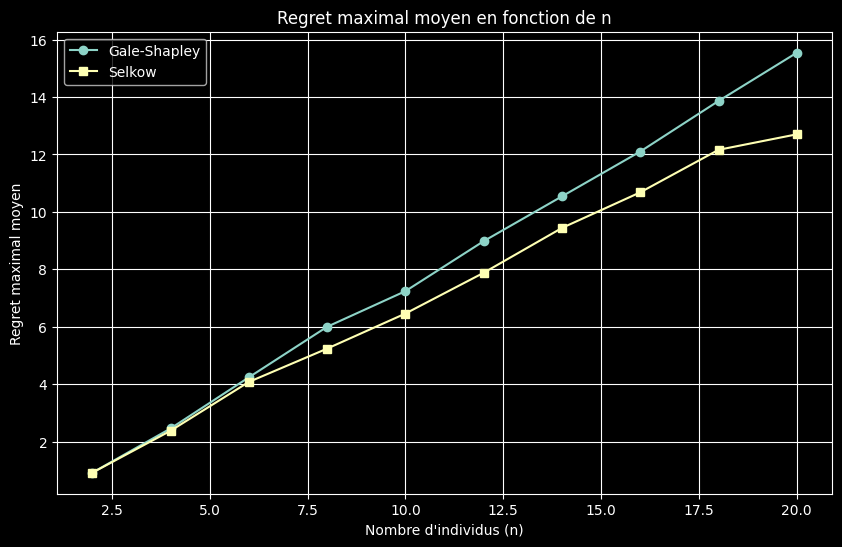

In [20]:
def simulate_regret_max(n_values, num_trials):
    gs_regret_max_list = []
    selkow_regret_max_list = []

    for n in n_values:
        gs_regrets = []
        selkow_regrets = []

        for _ in range(num_trials):
            # Générer des préférences aléatoires pour les deux populations
            p1Pref = dicoPrefGenerator(n)
            p2Pref = dicoPrefGenerator(n)

            # Exécuter Gale-Shapley
            gs_matching = galeShapley(p1Pref, p2Pref)
            gs_regret_max = regretMaximal(gs_matching, p1Pref, p2Pref)
            gs_regrets.append(gs_regret_max)

            # Exécuter Selkow
            selkow_matching = selkow(p1Pref, p2Pref)
            selkow_regret_max = regretMaximal(selkow_matching, p1Pref, p2Pref)
            selkow_regrets.append(selkow_regret_max)

        # Calculer le regret maximal moyen pour cette valeur de n
        gs_regret_mean = np.mean(gs_regrets)
        selkow_regret_mean = np.mean(selkow_regrets)

        gs_regret_max_list.append(gs_regret_mean)
        selkow_regret_max_list.append(selkow_regret_mean)

    return gs_regret_max_list, selkow_regret_max_list

# Paramètres de la simulation
n_values = range(2, 21, 2)  # n variant de 2 à 20 par pas de 2
num_trials = 50  # Nombre de simulations pour chaque valeur de n

# Exécuter la simulation
gs_regret_max_list, selkow_regret_max_list = simulate_regret_max(n_values, num_trials)

# Tracer les résultats
plt.figure(figsize=(10, 6))
plt.plot(n_values, gs_regret_max_list, marker='o', label='Gale-Shapley')
plt.plot(n_values, selkow_regret_max_list, marker='s', label='Selkow')
plt.title('Regret maximal moyen en fonction de n')
plt.xlabel('Nombre d\'individus (n)')
plt.ylabel('Regret maximal moyen')
plt.legend()
plt.grid(True)
plt.show()


**Interprétation des résultats :**  
En exécutant ce code, nous obtenons un graphique qui montre comment le regret maximal moyen évolue en fonction de la taille des populations pour les deux algorithmes.
- **Algorithme de Gale-Shapley :** Le regret maximal moyen augmente généralement avec la taille de la population. Cela est attendu, car avec plus d'individus, il est plus probable que certains aient des regrets élevés.
- **Algorithme de Selkow :** Le regret maximal moyen est systématiquement inférieur à celui de Gale-Shapley. Cela confirme que l'algorithme de Selkow parvient à minimiser le regret maximal, rendant les mariages plus équitables.

**Constatations :**  
- L'algorithme de Selkow réduit significativement le regret maximal par rapport à Gale-Shapley.
- La différence entre les deux algorithmes devient plus prononcée avec l'augmentation de la taille des populations.

> __Question 6 (carte blanche)__ : N'hésitez pas à pousser l'analyse : complexité, regrets moyens de chaque population... Lancez-vous ! Mais sans oublier de commenter vos observations.

Pour approfondir l'analyse, nous allons examiner plusieurs aspects :  
- **Complexité temporelle des algorithmes :**
  - **Gale-Shapley :** La complexité est en $O(n²)$, car chaque individu peut proposer à chaque membre de l'autre population au pire des cas.
  - **Selkow :** Puisqu'il utilise Gale-Shapley de manière itérative et modifie les préférences, sa complexité est supérieure, potentiellement jusqu'à $O(n³)$ dans le pire des cas.
- **Regrets moyens des deux populations :** Nous allons calculer le regret moyen pour chaque population séparément et comparer les résultats entre les deux algorithmes.

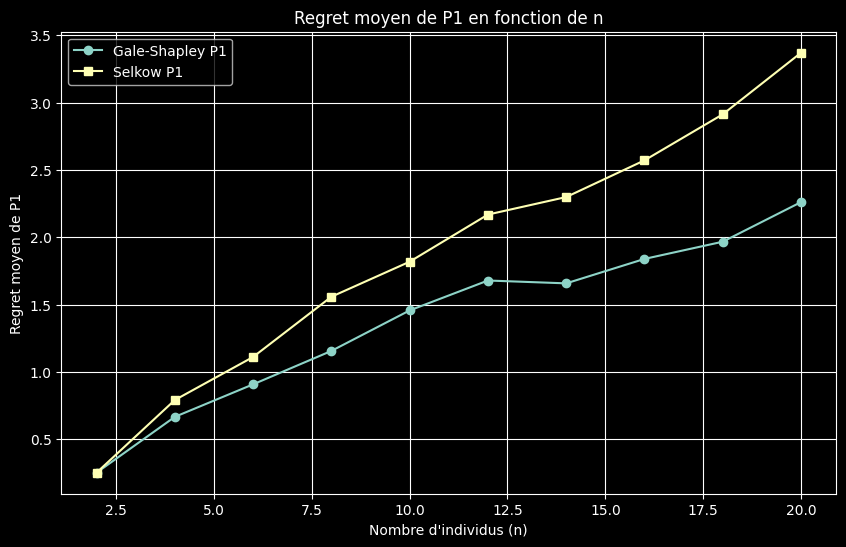

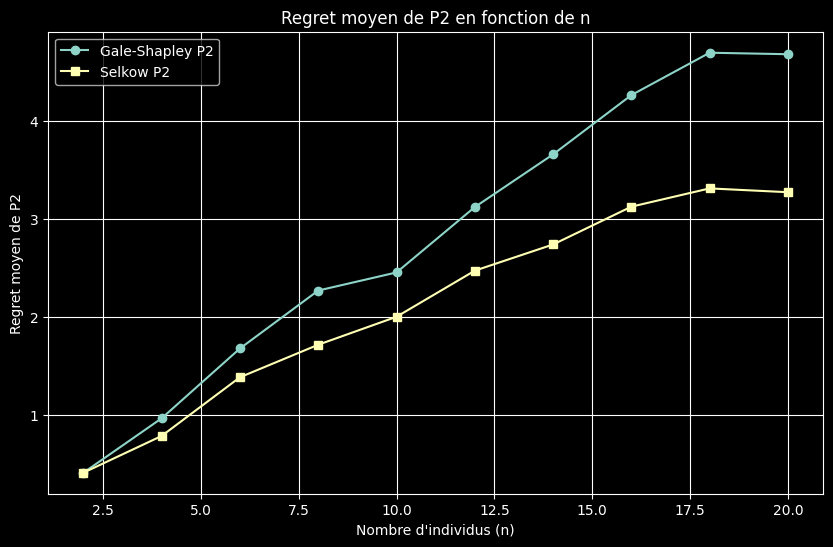

In [21]:
def simulate_regret_mean(n_values, num_trials):
    gs_regret_p1_mean_list = []
    gs_regret_p2_mean_list = []
    selkow_regret_p1_mean_list = []
    selkow_regret_p2_mean_list = []

    for n in n_values:
        gs_regrets_p1 = []
        gs_regrets_p2 = []
        selkow_regrets_p1 = []
        selkow_regrets_p2 = []

        for _ in range(num_trials):
            # Générer des préférences aléatoires pour les deux populations
            p1Pref = dicoPrefGenerator(n)
            p2Pref = dicoPrefGenerator(n)

            # Exécuter Gale-Shapley
            gs_matching = galeShapley(p1Pref, p2Pref)
            gs_regrets = regrets(gs_matching, p1Pref, p2Pref)
            gs_regrets_p1.extend(gs_regrets[0].values())
            gs_regrets_p2.extend(gs_regrets[1].values())

            # Exécuter Selkow
            selkow_matching = selkow(p1Pref, p2Pref)
            selkow_regrets = regrets(selkow_matching, p1Pref, p2Pref)
            selkow_regrets_p1.extend(selkow_regrets[0].values())
            selkow_regrets_p2.extend(selkow_regrets[1].values())

        # Calculer le regret moyen pour chaque population
        gs_regret_p1_mean = np.mean(gs_regrets_p1)
        gs_regret_p2_mean = np.mean(gs_regrets_p2)
        selkow_regret_p1_mean = np.mean(selkow_regrets_p1)
        selkow_regret_p2_mean = np.mean(selkow_regrets_p2)

        gs_regret_p1_mean_list.append(gs_regret_p1_mean)
        gs_regret_p2_mean_list.append(gs_regret_p2_mean)
        selkow_regret_p1_mean_list.append(selkow_regret_p1_mean)
        selkow_regret_p2_mean_list.append(selkow_regret_p2_mean)

    return (gs_regret_p1_mean_list, gs_regret_p2_mean_list,
            selkow_regret_p1_mean_list, selkow_regret_p2_mean_list)

# Paramètres de la simulation
n_values = range(2, 21, 2)
num_trials = 50

# Exécuter la simulation
(gs_regret_p1_mean_list, gs_regret_p2_mean_list,
 selkow_regret_p1_mean_list, selkow_regret_p2_mean_list) = simulate_regret_mean(n_values, num_trials)

# Tracer les résultats pour P1
plt.figure(figsize=(10, 6))
plt.plot(n_values, gs_regret_p1_mean_list, marker='o', label='Gale-Shapley P1')
plt.plot(n_values, selkow_regret_p1_mean_list, marker='s', label='Selkow P1')
plt.title('Regret moyen de P1 en fonction de n')
plt.xlabel('Nombre d\'individus (n)')
plt.ylabel('Regret moyen de P1')
plt.legend()
plt.grid(True)
plt.show()

# Tracer les résultats pour P2
plt.figure(figsize=(10, 6))
plt.plot(n_values, gs_regret_p2_mean_list, marker='o', label='Gale-Shapley P2')
plt.plot(n_values, selkow_regret_p2_mean_list, marker='s', label='Selkow P2')
plt.title('Regret moyen de P2 en fonction de n')
plt.xlabel('Nombre d\'individus (n)')
plt.ylabel('Regret moyen de P2')
plt.legend()
plt.grid(True)
plt.show()


**Observations :**  
- **Pour P1 :** Dans l'algorithme de Gale-Shapley, P1 est la population proposante, ce qui lui donne un avantage. Le regret moyen de P1 est donc généralement inférieur à celui de P2.
- **Pour P2 :** Dans Gale-Shapley, P2 subit les propositions, ce qui se traduit par un regret moyen plus élevé.
- **Algorithme de Selkow :** Les regrets moyens de P1 et P2 sont plus équilibrés. L'algorithme cherche à minimiser le regret maximal, ce qui conduit à une répartition plus équitable des regrets entre les deux populations.

**Conclusion :**  
- **Équité améliorée avec Selkow :** L'algorithme de Selkow parvient à réduire le regret maximal et à équilibrer les regrets moyens entre les deux populations, conduisant à des mariages plus équitables.
- **Coût en complexité :** Cette amélioration de l'équité se fait au prix d'une complexité algorithmique supérieure. Pour de très grandes populations, l'algorithme de Selkow peut être moins efficace en termes de temps de calcul.
- **Choix de l'algorithme :** Le choix entre les deux algorithmes dépend du contexte. Si l'équité est primordiale et que le temps de calcul est acceptable, Selkow est préférable. Sinon, Gale-Shapley reste une solution efficace pour obtenir des mariages stables rapidement.